In [1]:
import numpy as np
import torch
import smplx

In [2]:
amass_data_file = 'dataset/amass/ACCAD/ACCAD/Male2General_c3d/A4- Look Around_poses.npz'
amass_data = np.load(amass_data_file)

In [3]:
all_keys = list(amass_data.keys())
print(all_keys)

['trans', 'gender', 'mocap_framerate', 'betas', 'dmpls', 'poses']


In [4]:
poses_ds = amass_data['poses']
trans_ds = amass_data['trans']
betas_ds = amass_data['betas']
dmpls_ds = amass_data['dmpls']
gender_ds = amass_data['gender']
mocap_framerate_ds = amass_data['mocap_framerate']

print('poses.shape: ', poses_ds.shape)
print('trans.shape: ', trans_ds.shape)
print('betas.shape: ', betas_ds.shape)
print('dmpls.shape: ', dmpls_ds.shape)
print('gender: ', gender_ds)
print('mocap_framerate: ', mocap_framerate_ds)

poses.shape:  (1926, 156)
trans.shape:  (1926, 3)
betas.shape:  (16,)
dmpls.shape:  (1926, 8)
gender:  male
mocap_framerate:  120.0


In [5]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device: ', comp_device)
time_length = len(amass_data['trans'])

num_betas = 16 # number of body shape parameters
num_dmpls = 8 # number of DMPL parameters

body_parms = {
    'root_orient': torch.Tensor(amass_data['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(amass_data['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(amass_data['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(amass_data['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(amass_data['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    'dmpls': torch.Tensor(amass_data['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

other_parms = {
    'gender': gender_ds.item(),
    'mocap_framerate': mocap_framerate_ds.item()
}

Using device:  cuda


In [6]:
model_folder = './dataset/smpl'
model_type = 'smplx'
use_face_contour = False
num_betas = 16
num_expression_coeffs = 10
ext = 'npz'
gender = gender_ds.item()

model = smplx.create(model_folder, model_type=model_type,
                        gender=gender, use_face_contour=use_face_contour,
                        num_betas=num_betas,
                        num_expression_coeffs=num_expression_coeffs,
                        ext=ext)
model = model.to(comp_device)
print(model)

SMPLX(
  Gender: MALE
  Number of joints: 55
  Betas: 16
  Number of PCA components: 6
  Flat hand mean: False
  Number of Expression Coefficients: 10
  (vertex_joint_selector): VertexJointSelector()
)


In [7]:
# visualize the first frame
body_pose = body_parms['pose_body'][0].reshape(1, -1)
betas = body_parms['betas'][0].reshape(1, -1)
output = model(betas=betas,
                body_pose=body_pose, 
                global_orient=body_parms['root_orient'][0].reshape(1, -1),
                transl=body_parms['trans'][0].reshape(1, -1),
                return_verts=True)

In [8]:
vertices = output.vertices.detach().cpu().numpy().squeeze()
joints = output.joints.detach().cpu().numpy().squeeze()
joints_no_face_hand = joints[:22, :]

print('Vertices shape =', vertices.shape)
print('Joints shape =', joints.shape)
print('Joints no face and hands shape =', joints_no_face_hand.shape)

Vertices shape = (10475, 3)
Joints shape = (127, 3)
Joints no face and hands shape = (22, 3)


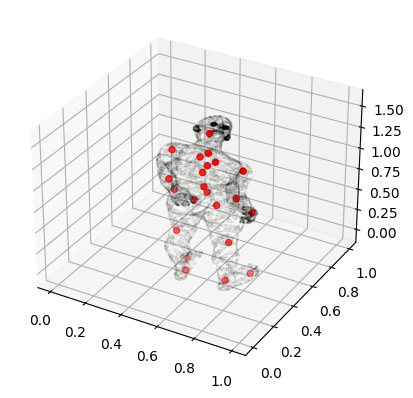

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(vertices[model.faces][::5], alpha=0.1)
face_color = (1.0, 1.0, 0.9)
edge_color = (0, 0, 0)
mesh.set_edgecolor(edge_color)
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)
ax.scatter(joints_no_face_hand[:, 0], joints_no_face_hand[:, 1], joints_no_face_hand[:, 2], color='r')

In [10]:
from poselib.skeleton.skeleton3d import SkeletonTree, SkeletonState, SkeletonMotion
from poselib.visualization.common import plot_skeleton_state, plot_skeleton_motion_interactive
from poselib.core.rotation3d import *

2024-10-09 06:20:23,353 - INFO - logger - logger initialized


2024-10-09 06:20:23,528 - INFO - common - plotting 


{'name': 'Pelvis', 'pos': '-0.0024 -0.2414 0.0298'}
{'name': 'L_Hip', 'pos': '-0.0173 0.0589 -0.0825'}
{'name': 'L_Knee', 'pos': '0.0082 0.0434 -0.3872'}
{'name': 'L_Ankle', 'pos': '-0.0376 -0.015 -0.4293'}
{'name': 'L_Toe', 'pos': '0.1227 0.0408 -0.0605'}
{'name': 'R_Hip', 'pos': '-0.0131 -0.0606 -0.0908'}
{'name': 'R_Knee', 'pos': '-0.0049 -0.0432 -0.3846'}
{'name': 'R_Ankle', 'pos': '-0.0348 0.0192 -0.4224'}
{'name': 'R_Toe', 'pos': '0.131 -0.0352 -0.0622'}
{'name': 'Torso', 'pos': '-0.0393 0.0045 0.125'}
{'name': 'Spine', 'pos': '0.0265 0.0045 0.1381'}
{'name': 'Chest', 'pos': '0.0029 -0.0022 0.0561'}
{'name': 'Neck', 'pos': '-0.034 -0.0134 0.2126'}
{'name': 'Head', 'pos': '0.0502 0.0102 0.0885'}
{'name': 'L_Thorax', 'pos': '-0.0189 0.0722 0.1146'}
{'name': 'L_Shoulder', 'pos': '-0.0193 0.1237 0.0454'}
{'name': 'L_Elbow', 'pos': '-0.0236 0.2562 -0.0158'}
{'name': 'L_Wrist', 'pos': '-0.0071 0.2675 0.013'}
{'name': 'L_Hand', 'pos': '-0.0157 0.0874 -0.0107'}
{'name': 'R_Thorax', 'pos'

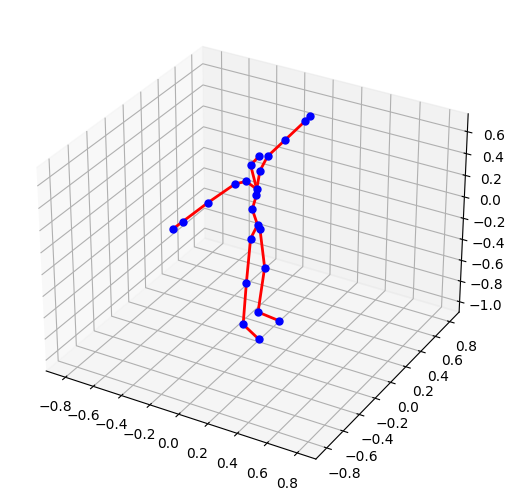

In [11]:
smpl_mjcf_file = 'mjcf/smpl/smpl.xml'
smpl_tpose = SkeletonTree.from_mjcf(smpl_mjcf_file)
smpl_zero_pose = SkeletonState.zero_pose(smpl_tpose)
plot_skeleton_state(smpl_zero_pose)

In [12]:
num_motion_frames = body_parms['pose_body'].shape[0]
smpl_node_name_order = ['Pelvis',  # 0
                        'R_Hip',  # 1
                        'L_Hip',  # 2
                        'Torso',  # 3 (spine1)
                        'R_Knee',  # 4
                        'L_Knee',  # 5
                        'Spine',  # 6 (spine2)
                        'R_Ankle',  # 7
                        'L_Ankle',  # 8
                        'Chest',  # 9 (spine3)
                        'R_Toe',  # 10
                        'L_Toe',  # 11
                        'Neck',  # 12
                        'R_Thorax',  # 13 (r_collar)
                        'L_Thorax',  # 14 (l_collar)
                        'Head',  # 15
                        'R_Shoulder',  # 16
                        'L_Shoulder',  # 17
                        'R_Elbow',  # 18
                        'L_Elbow',  # 19
                        'R_Wrist',  # 20
                        'L_Wrist',  # 21
                        'R_Hand',  # 22
                        'L_Hand'  # 23
                        ]

pose_list = []

for i in range(num_motion_frames):
    body_pose = body_parms['pose_body'][i]
    cur_pose = SkeletonState.zero_pose(smpl_tpose)
    for j in range(22): # drop left hand, right hand
        print('local node name =', smpl_node_name_order[j], 'idx =', j)
        if smpl_node_name_order[j] == 'Head':
            print('skip head')
            continue
        angle = body_pose[3*j:3*(j+1)] if j<smpl_node_name_order.index('Head') else body_pose[3*(j-1):3*j]
        angle_deg = torch.linalg.norm(angle) * 180 / np.pi
        angle_axis = angle / torch.linalg.norm(angle)
        node_rot = quat_from_angle_axis(angle_deg, angle_axis)
        cur_pose.local_rotation[smpl_tpose.index(smpl_node_name_order[j])] = quat_mul(node_rot, 
                            smpl_zero_pose.local_rotation[smpl_tpose.index(smpl_node_name_order[j])])

    pose_list.append(cur_pose)
    break

local node name = Pelvis idx = 0
tensor([0., 0., 0., 1.])
local node name = R_Hip idx = 1
tensor([0., 0., 0., 1.])
local node name = L_Hip idx = 2
tensor([0., 0., 0., 1.])
local node name = Torso idx = 3
tensor([0., 0., 0., 1.])
local node name = R_Knee idx = 4
tensor([0., 0., 0., 1.])
local node name = L_Knee idx = 5
tensor([0., 0., 0., 1.])
local node name = Spine idx = 6
tensor([0., 0., 0., 1.])
local node name = R_Ankle idx = 7
tensor([0., 0., 0., 1.])
local node name = L_Ankle idx = 8
tensor([0., 0., 0., 1.])
local node name = Chest idx = 9
tensor([0., 0., 0., 1.])
local node name = R_Toe idx = 10
tensor([0., 0., 0., 1.])
local node name = L_Toe idx = 11
tensor([0., 0., 0., 1.])
local node name = Neck idx = 12
tensor([0., 0., 0., 1.])
local node name = R_Thorax idx = 13
tensor([0., 0., 0., 1.])
local node name = L_Thorax idx = 14
tensor([0., 0., 0., 1.])
local node name = Head idx = 15
skip head
local node name = R_Shoulder idx = 16
tensor([0., 0., 0., 1.])
local node name = L_Sho

2024-10-09 06:20:23,983 - INFO - common - plotting 


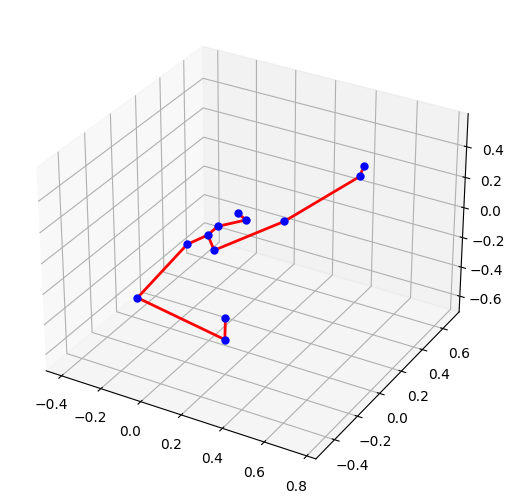

In [13]:
# draw the first frame
plot_skeleton_state(pose_list[0])